<a href="https://colab.research.google.com/github/dlwogns/ML-DL/blob/main/GoDaddy%20-%20Microbusiness%20Density%20Forecasting/ARIMA_godaddy_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA 
## reference
https://www.kaggle.com/code/tanmay111999/gdmbf-ar-ma-arma-arima-sarima-auto-arima <br>
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ <br>

Addivtive model -> 선형 (덧셈 분해) <br>
Multiplicative model -> 비선형 (곱셈 분해)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [5]:
train = pd.read_csv("/content/drive/MyDrive/data/GoDaddy/train.csv")
test = pd.read_csv("/content/drive/MyDrive/data/GoDaddy/test.csv")
census = pd.read_csv("/content/drive/MyDrive/data/GoDaddy/census_starter.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/data/GoDaddy/sample_submission.csv")

In [6]:
data = train[['first_day_of_month', 'microbusiness_density']].copy(deep = True)
data['Date'] = pd.to_datetime(data['first_day_of_month'])
data = data.drop(columns = 'first_day_of_month')
data = data.set_index('Date')
data

,microbusiness_density
Date,
2019-08-01,3.007682
2019-09-01,2.884870
2019-10-01,3.055843
2019-11-01,2.993233
2019-12-01,2.993233
...,...
2022-06-01,1.803249
2022-07-01,1.803249
2022-08-01,1.785395


In [7]:
data.microbusiness_density.describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

In [8]:
data = data.groupby(data.index).mean()
data.head()

,microbusiness_density
Date,
2019-08-01,3.749621
2019-09-01,3.696846
2019-10-01,3.778263
2019-11-01,3.722510
2019-12-01,3.717284


In [9]:
plt.figure(figsize = (20,10))

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

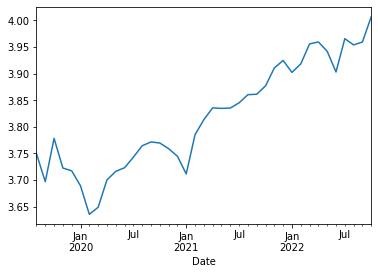

In [10]:
data['microbusiness_density'].plot();

이 그래프에 따라서는 계절성에 정보가 파악될 수 없고, 1월 주변에 큰 폭으로 값이 하락하는 것을 알 수 있다. 반면에, 우상향의 추세가 관찰되므로 덧셈분해를 통해 분해하겠다.

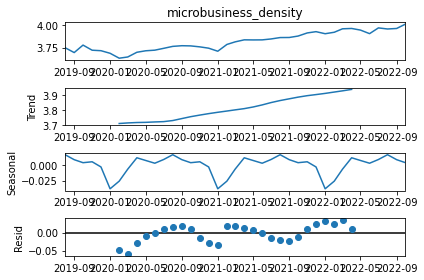

In [11]:
dec = sm.tsa.seasonal_decompose(data['microbusiness_density'], period = 12, model = 'additive').plot()

데이터는 우상향의 추세를 가지고 있고 <br>
1년 주기의 계절성을 가지고 있다.

In [12]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

For the Null Hypothesis to be rejected and accepting that the time series is stationary, there are 2 requirements :
Critical Value (5%) > Test Statistic
<br>p-value < 0.05

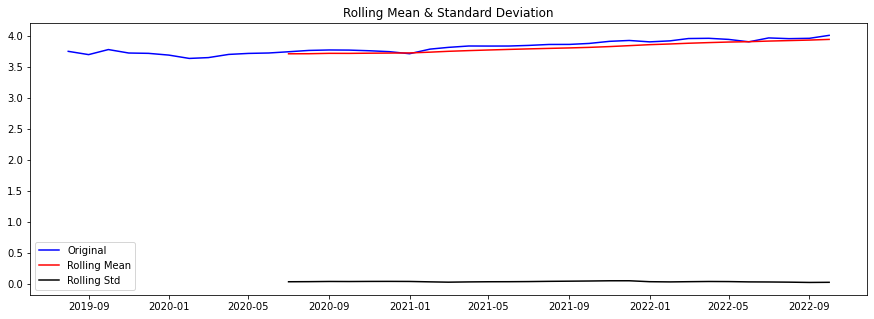

Results of Dickey-Fuller Test:
Test Statistic                 -0.176712
p-value                         0.941241
#Lags Used                      0.000000
Number of Observations Used    38.000000
Critical Value (1%)            -3.615509
Critical Value (5%)            -2.941262
Critical Value (10%)           -2.609200
dtype: float64


In [13]:
test_stationarity(data['microbusiness_density'])

위의 두가지 조건을 만족하지 않기 때문에, 항상성이 없다고 판단.

항상성이 없는 그래프에 항상성을 만들어주기 위해, 차분을 사용할 것이다.

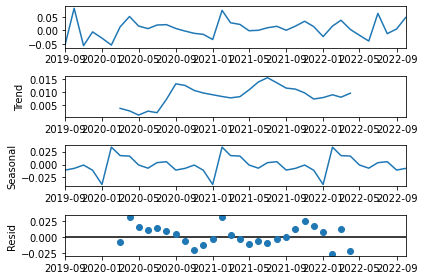

In [14]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff, period = 12).plot()

추세는 날라갔지만, 계절성은 남아있다.

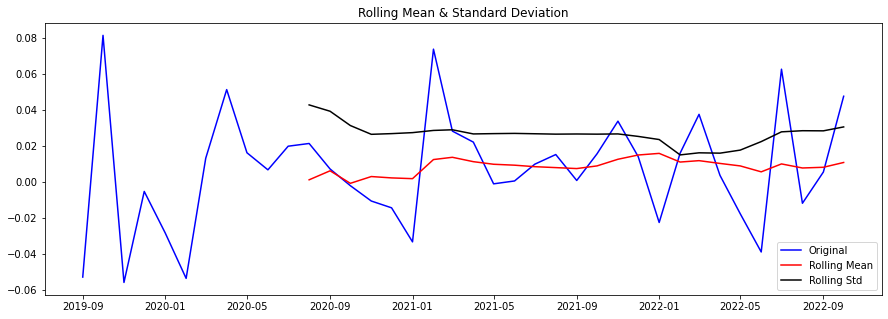

Results of Dickey-Fuller Test:
Test Statistic                 -4.592181
p-value                         0.000134
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


In [15]:
test_stationarity(data_diff)

For any Time Series Analysis problem, series being stationary is very critical as majority of the models assume stationarity, trend & seasonality have been dealt with!


In [16]:
# cfip과 censor data까지 고려해주어야 하지만, 여기서 추세를 파악하기 위해 일단은 
# 전체의 평균을 내버렸다.
# data = data.groupby(data.index).mean()
# data

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
  #신뢰구간이 어딧지..
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## AR
AR은 이전의 시간에서의 같은 입력 값을 사용하는 모델이다.<br>
이것의 원리는 이전의 관찰들이 미래의 값을 예측하는데 중요하다는 것 이다.<br>
현재와 특정한 시점의 과거의 값의 관계를 파악하는 것 이기 때문에, 이것은 자기상관으로 알려지기도 한다. <br>
자기상관이 강할수록, AR은 더 높은 가중치를 준다. <br>


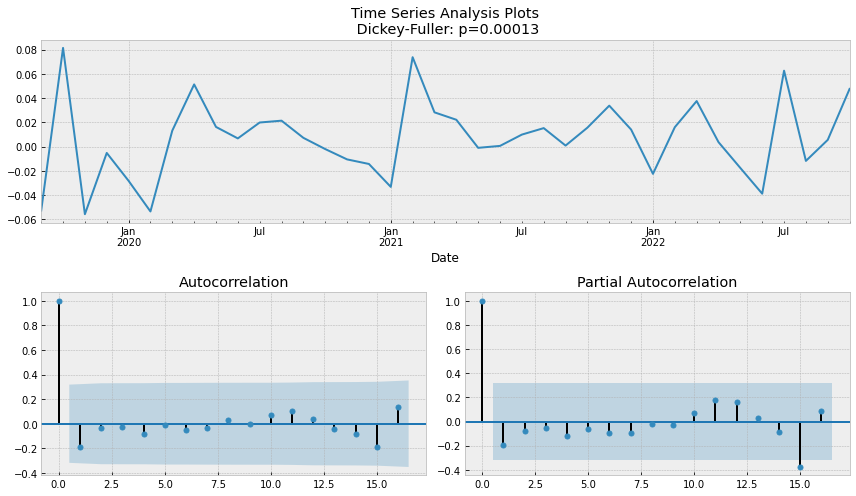

In [18]:
tsplot(data_diff['microbusiness_density'])

In the above plots of correlations, we can see the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis along with a confidence interval (blue region) for the correlation values.
<br>
신뢰구간이 의미하는게 뭔지 잘 모르겠음. 
-> 백색오차는 관련 수식 기준으로 값이 95% 이상 들어가야 된다. data_diff 는 항상성을 위해 differencing을 사용한 결과이므로, 여기서 신뢰구간이 기인한 것이라고 볼 수 있다.

자기상관 값에서, 특정한 lag를 찾지 못했기 때문에 AR(P)를 0으로 둔다. (0, 0, 0)


## MA
MA는 현재의 값이 현재와 과거의 오차항에 선형적으로 의존하는것을 가정하는 모델입니다. <br>
In order to find the order of the MA model, autocorrelation graph is looked at by assuming the time series has been made stationary.,<br>
MA model의 순서를 찾기 위해서, 자기상관 그래프는 시계열 연산의 그래프가 stationary하다고 가정한다.<br>
If none of the significant lags are found, MA model becomes redundant and it is known as random walk.
<br>
참조 -> velog stationarity



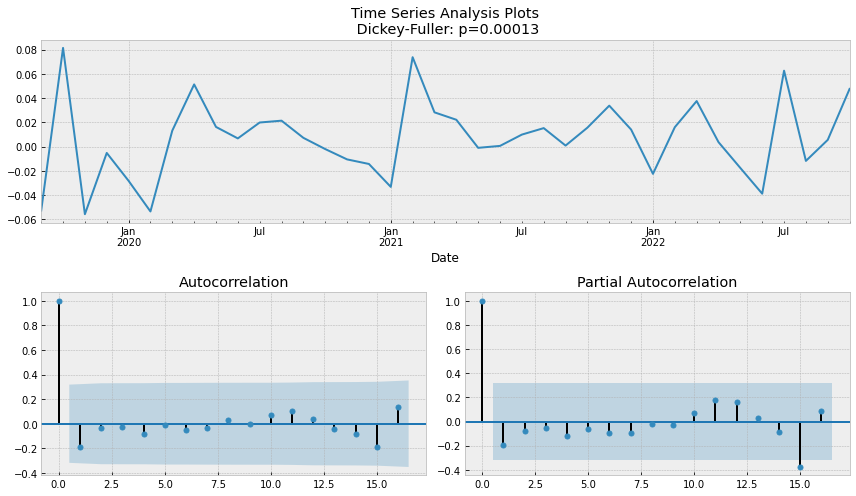

In [19]:
tsplot(data_diff['microbusiness_density'])

AR과 비슷하게, significant lags are not found. so MA(q) : 0.

## ARIMA
p : Number of auto regressive terms<br>
d : Number of differencing orders required to make the time series stationary<br>
q : Number of lagged forecast errors in the prediction equation <br>
Selection criteria for the order of ARIMA model<br>
p : lah value where the Partial Actocorrelation graph cuts off or drops to 0 for the 1st instance<br>
d : Number of times differencing is carried out to make the time series stationary<br>
q : lag value where the Autocorrelation graph crosses the upper confidence interval for the 1st instance

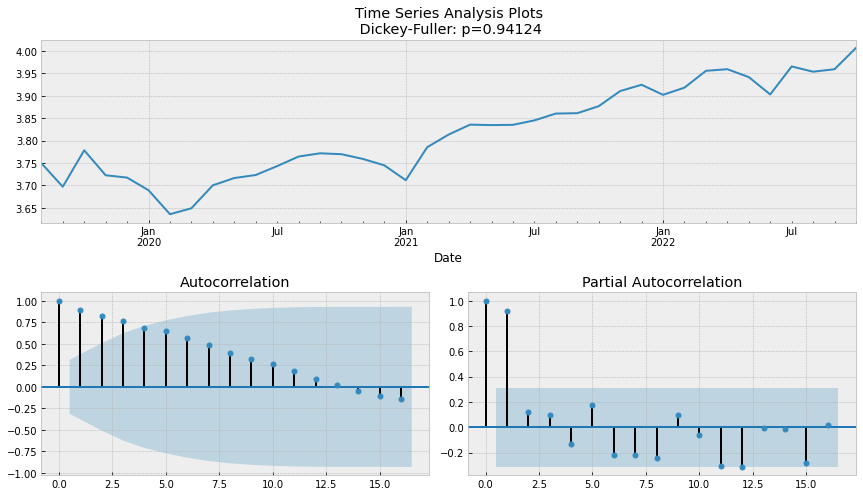

In [20]:
tsplot(data['microbusiness_density'])

In [21]:
model = ARIMA(data['microbusiness_density'], order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(0, 1, 0)   Log Likelihood                  76.040
Date:                   Thu, 16 Feb 2023   AIC                           -150.080
Time:                           07:29:13   BIC                           -148.442
Sample:                       08-01-2019   HQIC                          -149.497
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011      0.000      4.494      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                 0.13
Prob(Q):               

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


## SARIMA
계절성 까지 다룰 수 있는 ARIMA의 응용 모델.


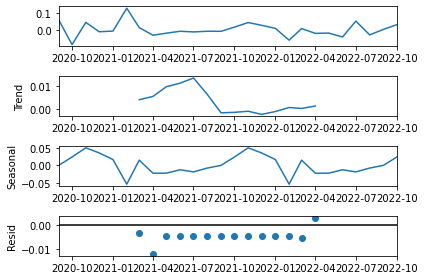

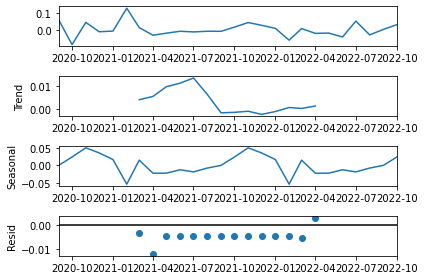

In [22]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas, period = 12)
dec.plot()

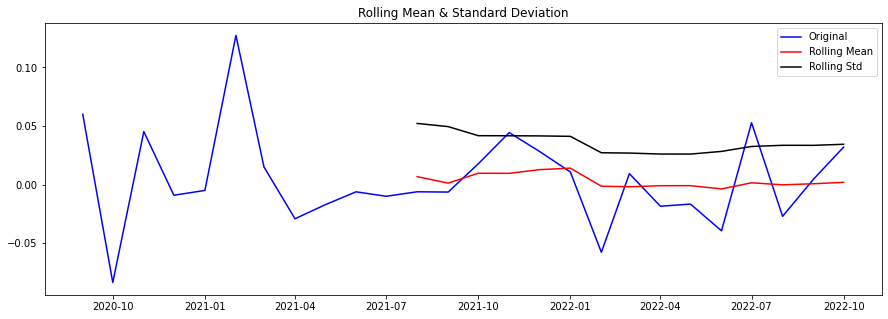

Results of Dickey-Fuller Test:
Test Statistic                -6.181386e+00
p-value                        6.442529e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+01
Critical Value (1%)           -3.723863e+00
Critical Value (5%)           -2.986489e+00
Critical Value (10%)          -2.632800e+00
dtype: float64


In [23]:
test_stationarity(data_diff_seas['microbusiness_density'])

In [24]:
model = sm.tsa.statespace.SARIMAX(data['microbusiness_density'], order=(0,1,0), seasonal_order = (0,1,0,12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:              microbusiness_density   No. Observations:                   39
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  46.115
Date:                            Thu, 16 Feb 2023   AIC                            -90.230
Time:                                    07:29:14   BIC                            -88.971
Sample:                                08-01-2019   HQIC                           -89.867
                                     - 10-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0017      0.000      4.984      0.000       0.001       0.002
Ljung-Box (L1) (Q):                

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [25]:
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])
df1 = test.copy(deep = True)
df1 = df1.set_index('first_day_of_month')
df1 = df1.groupby(df1.index).mean()
df1

,cfips
first_day_of_month,
2022-11-01,30376.03764
2022-12-01,30376.03764
2023-01-01,30376.03764
2023-02-01,30376.03764
2023-03-01,30376.03764
2023-04-01,30376.03764
2023-05-01,30376.03764
2023-06-01,30376.03764


## Rolling prediction
하나씩 값을 구한다음 그것을 다시 인자로 사용해 새로운 값을 도출.

In [26]:
history_f = [x for x in data['microbusiness_density']]
f1 = []
for t in tqdm(range(len(df1))):
  #model = ARIMA(history_f, order = (0,1,0))
  model = sm.tsa.statespace.SARIMAX(history_f, order = (0,1,0), seasonal_order = (0,1,0,12))
  model_fit = model.fit()
  output = model_fit.forecast()[0]
  history_f.append(output)
  f1.append(output)

df1['forecast'] = 0
for i in range(len(f1)):
  df1.iloc[i, 1] = f1[i]

df1
  

 75%|███████▌  | 6/8 [00:00<00:00, 29.20it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 8/8 [00:00<00:00, 25.50it/s]


,cfips,forecast
first_day_of_month,,
2022-11-01,30376.03764,4.040741
2022-12-01,30376.03764,4.054802
2023-01-01,30376.03764,4.032337
2023-02-01,30376.03764,4.048347
2023-03-01,30376.03764,4.085913
2023-04-01,30376.03764,4.089601
2023-05-01,30376.03764,4.071960
2023-06-01,30376.03764,4.033122


## Non-Rolling prediction
한번에 여러개.

In [27]:
df1['forecast'] = 0
f2 = np.array(model_fit.forecast(steps = 8))

for i in range(len(f2)):
  df1.iloc[i,1] = f2[i]
df1

,cfips,forecast
first_day_of_month,,
2022-11-01,30376.03764,4.033122
2022-12-01,30376.03764,4.095754
2023-01-01,30376.03764,4.083959
2023-02-01,30376.03764,4.089519
2023-03-01,30376.03764,4.137124
2023-04-01,30376.03764,4.170902
2023-05-01,30376.03764,4.184963
2023-06-01,30376.03764,4.162498


## Approach 2

In [28]:
df1 = train[['first_day_of_month', 'microbusiness_density', 'cfips']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips', 'Date']).sum()
df1

microbusiness_density
cfips Date                             
1001  2019-08-01               3.007682
      2019-09-01               2.884870
      2019-10-01               3.055843
      2019-11-01               2.993233
      2019-12-01               2.993233
...                                 ...
56045 2022-06-01               1.803249
      2022-07-01               1.803249
      2022-08-01               1.785395
      2022-09-01               1.785395
      2022-10-01               1.785395

[122265 rows x 1 columns]

In [29]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')
df2 = df2.groupby(['cfips', 'Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

## Rolling 

In [36]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):
  history_f = [x[0] for x in df1.loc[int(i), :].values]
  f1 = []

  for t in range(len(df2.loc[int(i), :])):
    model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
    model_fit = model.fit()

    output = model_fit.forecast()[0]

    history_f.append(output)
    f1.append(output)
  print(f1)



0it [00:00, ?it/s]


TypeError: ignored

In [31]:
df2

row_id  microbusiness_density
cfips Date                                               
1001  2022-11-01   1001_2022-11-01               3.606733
      2022-12-01   1001_2022-12-01               3.606733
      2023-01-01   1001_2023-01-01               3.606733
      2023-02-01   1001_2023-02-01               3.606733
      2023-03-01   1001_2023-03-01               3.606733
...                            ...                    ...
56045 2023-02-01  56045_2023-02-01               1.918086
      2023-03-01  56045_2023-03-01               1.918086
      2023-04-01  56045_2023-04-01               1.918086
      2023-05-01  56045_2023-05-01               1.918086
      2023-06-01  56045_2023-06-01               1.918086

[25080 rows x 2 columns]

## Non Rolling

In [ ]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):
  history_f = [x[0] for x in df1.loc[int(i), :].values]
  model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12))
  model_fit = model.fit()

  f2 = np.array(model.fit.forecast(steps = 8))



## Approach 3

In [37]:
!pip install pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.8 MB/s eta 0:00:00


In [43]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.is_stationary(data_diff)

<ipython-input-43-711e08b6b0e0>:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  adf_test.is_stationary(data_diff)


(0.05252845246985464, True)

다변수 이기 때문에 VARMAX사용.
census data 정리해서, stationarity 맞춰서 dataset하나 만들고 cfip별로 autoarima 돌리고,
https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/